## Compare BERT Summarization model and Gensim Summarization model using BBC news

#### BBC news classification
#### Automatic Summarization model comparison between BERT and Gensim
#### Use One-vs-the-rest (OvR) multiclass/multilabel strategy as strategy for multiclass classification

The objective of this article is to evaluate Text Summarization models by comparing classification accuracy before and after Text Summarization on BBC news with
two methods:
    - gensim.summarization
    - bert-extractive-summarizer 

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modeling. 
This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

In [1]:
#pip
!pip install bert-extractive-summarizer 
!pip install transformers
!pip3 install torch==1.3.1+cpu torchvision==0.4.2+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-pretrained-bert

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Looking in links: https://download.pytorch.org/whl/torch_stable.html


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
###NOTE: You will need spacy 2.1.3 installed. There is currently an issue with Spacy 2.1.4 that produces segmentation faults.

In [1]:
import spacy
spacy.__version__

'2.1.3'

##  Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from numpy import random

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd

import nltk
from nltk import Text
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from string import punctuation
from heapq import nlargest
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import  SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import roc_curve, precision_recall_curve,auc
from sklearn.metrics import average_precision_score,cohen_kappa_score

from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import gensim
from gensim.summarization import summarize
#from gensim.utils import lemmatize
from textblob import TextBlob
from textblob import Word

from summarizer import Summarizer #bert

### Create dataframe from mulitiple data files. 
Data source: https://www.bonaccorso.eu/wp-content/uploads/2016/12/bbc.html

In [3]:
data_folder = "../bbc"
folders = ["business","entertainment","politics","sport","tech"]
try:
    os.chdir("../bbc")
except:
    os.chdir("./bbc")
    
x = []
y = []

for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" + text_file
        with open(file_path) as f:
            lines = f.readlines()
        record = ' '.join(lines)
        x.append(record)
        y.append(i)   
data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
df.to_csv('../bbc/dataset.csv', index=False)
print ('done writing csv flie')

done writing csv flie


## BBC news cleansing

In [4]:
news = pd.read_csv('../bbc/dataset.csv', delimiter=',',encoding = "ISO-8859-1")
# Associate Category names with numerical index and save it in new column category_id
news['category_id'] = news['type'].factorize()[0]
nRow, nCol = news.shape
nRow, nCol

(2225, 3)

In [5]:
# creation of the column count for aggregation
news['Count']=1
news[['type','Count']].groupby(['type'], as_index=False).count()

,type,Count
0,business,510
1,entertainment,386
2,politics,417
3,sport,511
4,tech,401


### Pretty balanced 

In [6]:
news.head(2)

,news,type,category_id,Count
0,Ad sales boost Time Warner profit\n \n Quarter...,business,0,1
1,Dollar gains on Greenspan speech\n \n The doll...,business,0,1


### Check the news length to make sure they are long enough for our purpose - evaluating text summarization

In [7]:
# keep all
news['newslen']=news['news'].apply(lambda x:len(x))
#news.sort_values(by='newslen', ascending=True) ##both ways work
news['newslen'].sort_values(axis=0, ascending=True)[0:10]

1292    507
1561    725
1515    733
1568    746
1319    747
1503    750
1818    761
1816    761
1810    764
1532    766
Name: newslen, dtype: int64

**Select text more than one sentence. Gensim will give error for one sentence text**

In [8]:
# Use RE to match text with only one appearance of . or ? or ! 
# [\w\W]* will match anything including return
news=news[news['news'].str.match(pat ='[\w\W]*[.?!][\w\W]*[.?!][\w\W]*')]
# Remove decimal part of a float number. Decimal point is treated as peroid when count sentences during summarization
news['news']=news['news'].str.replace('\.\d+', ' ', regex=True)
# add a space after '.' so Gensim will treat it as a sentence
news['news']=news['news'].str.replace('.', '. ', regex=False)
news['news']=news['news'].str.replace('?', '? ', regex=False)
news['news']=news['news'].str.replace('!', '! ', regex=False)


### Check any news only has one sentence 

In [9]:
news[~news['news'].str.match(pat ='[\w\W]*[.?!][\w\W]*[.?!][\w\W]*')]['news']

Series([], Name: news, dtype: object)

**Plot the count by type**

In [10]:
newsbyType=news.groupby('type', as_index=False).agg({"Count": "sum"})
newsbyType.head()

,type,Count
0,business,510
1,entertainment,386
2,politics,417
3,sport,511
4,tech,401


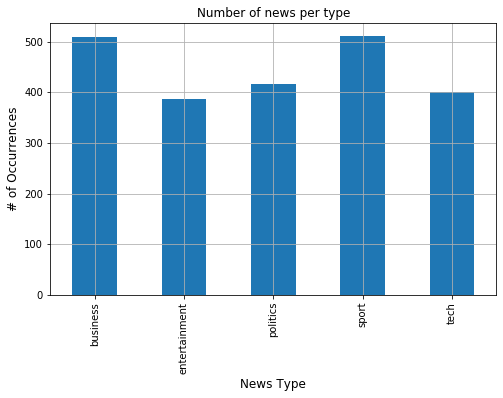

In [11]:
newsbyType.plot(x='type', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of news per type")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('News Type', fontsize=12)
plt.show()

In [12]:
news['news'][:4]

0    Ad sales boost Time Warner profit\n \n Quarter...
1    Dollar gains on Greenspan speech\n \n The doll...
2    Yukos unit buyer faces loan claim\n \n The own...
3    High fuel prices hit BA's profits\n \n British...
Name: news, dtype: object

### Clean the news text field

In [13]:
# function for cleaning the plots of the movies
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = text.strip(' ')# remove the leading and trailing space
    letteronly = re.compile('[^a-z #+_]') # only keep letters and a few symbol.
    text = letteronly.sub(' ', text) 

    
    #lemmatize
    #lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(text)] # give error in python3.7

    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    words  = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(words)


In [14]:
news['newsClean'] = news['news'].apply(clean_text)

In [15]:
news.newsClean[0:2].values

array(['ad sale boost time warner profit quarterly profit at u medium giant timewarner jump to bn m for the three month to december from m year earlier the firm which be now one of the big investor in google benefit from sale of high speed internet connection and high advert sale timewarner say fourth quarter sale rise to bn from bn it profit be buoy by one off gain which offset a profit dip at warner bros and less user for aol time warner say on friday that it now own of search engine google but it own internet business aol have have mix fortune it lose subscriber in the fourth quarter profit be low than in the preceding three quarter however the company say aol underlying profit before exceptional item rise on the back of strong internet advertising revenue it hop to increase subscriber by offer the online service free to timewarner internet customer and will try to sign up aol exist customer for high speed broadband timewarner also have to restate and result follow a probe by the u 

### get_dummies for target column

In [16]:
news=pd.get_dummies(data=news, columns=['type'])
news.columns

Index(['news', 'category_id', 'Count', 'newslen', 'newsClean', 'type_business',
       'type_entertainment', 'type_politics', 'type_sport', 'type_tech'],
      dtype='object')

## Model Training and Evaluation
### Use SGDClassifier classification models
### One-vs-the-rest (OvR) multiclass/multilabel strategy is the most commonly used strategy for multiclass classification and is a fair default choice.

In [17]:
X_train,X_test,y_train,y_test =  train_test_split(news['newsClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

### Use pipeline link preprocessing TFIDF and model fitting in a proper way so no data leaking from test to train

In [18]:
def DoClassification (model,method):
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words ='english',min_df=8, smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')),
    ('clf', model)])
    if method=='predit':
        y_score = pipeline.fit(X_train, y_train).predict(X_test)
    elif method=='predit_proba':
        y_score = pipeline.fit(X_train, y_train).predict_proba(X_test)
    elif method=='decision_function':
        y_score = pipeline.fit(X_train, y_train).decision_function(X_test)
    return(y_score )

### Create a dataframe to hold all scores

In [19]:
accuracy_classifier= pd.DataFrame(columns = ['type']) 

### Compute performance metrics for each class

In [20]:
def computeMetrics (metrics,y_score,classifiername):
    score = dict()
    for i in range(len(y_train.columns)):
        score[i] = metrics(y_test.iloc[:,i], y_score[:,i])
        accuracy_classifier.loc[i,'type'] = y_train.columns[i]
        accuracy_classifier.loc[i,classifiername+'_'+ metrics.__name__]=score[i]

** Average_precision_score is used since it handles unbalanced classes well. roc_auc_score and cohen_kappa_score can be tried for comparison. Cohen’s kappa statistic is a very good measure that can handle well both multi-class and imbalanced class problems. **

### SGDClassifier 

In [21]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'SGDClassifier')

In [22]:
accuracy_classifier

,type,SGDClassifier_average_precision_score
0,type_business,0.967659
1,type_entertainment,0.969602
2,type_politics,0.979938
3,type_sport,0.998669
4,type_tech,0.980444


### Evaluate Text Summarization models

**Gensim**

In [23]:
news.shape

(2225, 10)

In [24]:
news['newsSum']=news['news'].apply(lambda x:summarize(x,ratio=0.2)) ## default ratio=0.2

**Take a look at the Summarization**

In [25]:
news['news'].iloc[55:56].values

array(['BMW drives record sales in Asia\n \n BMW has forecast sales growth of at least 10% in Asia this year after registering record sales there in 2004. \n \n The luxury carmaker saw strong sales of its three marques - BMW, Mini and Rolls-Royce - in Asia last year after the launch of three new models.  The company, which is vying with Mercedes-Benz for the title of leading premium carmaker, is confident about its prospects for the region in 2005.  It is launching a revamped version of its 3-Series saloon class next month. \n \n BMW sold nearly 95,000 cars in Asia last year, up 2 % on 2003. \n \n BMW-brand sales rose 2 % to 80,600 while sales of Mini models rose 3 % to 14,800.  There was also a significant increase in sales of Rolls-Royces on the continent.  BMW sold more than 100 of the iconic models compared with just ten the previous year.  The German carmaker is aiming to boost annual sales in Asia to 150,000 by 2008.  "Here in Asia, we consider a double-digit increase in retail o

In [26]:
news['newsSum'].iloc[55:56].values

array(['The luxury carmaker saw strong sales of its three marques - BMW, Mini and Rolls-Royce - in Asia last year after the launch of three new models.\nBMW sold nearly 95,000 cars in Asia last year, up 2 % on 2003.\nBMW-brand sales rose 2 % to 80,600 while sales of Mini models rose 3 % to 14,800.'],
      dtype=object)

### Clean the Summarization text field

In [27]:
news['newsSumClean'] = news['newsSum'].apply(clean_text)

In [28]:
news['newsSumClean'].iloc[55:56].values

array(['the luxury carmaker saw strong sale of it three marque bmw mini and roll royce in asia last year after the launch of three new model bmw sell nearly car in asia last year up on bmw brand sale rise to while sale of mini model rise to'],
      dtype=object)

### Repeat the classifier evaluation using SGDClassifier on Summarization text using gensim summarizer

In [29]:
X_train,X_test,y_train,y_test =  train_test_split(news['newsSumClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

In [30]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'Gensim')

In [31]:
accuracy_classifier

,type,SGDClassifier_average_precision_score,Gensim_average_precision_score
0,type_business,0.967659,0.920503
1,type_entertainment,0.969602,0.933764
2,type_politics,0.979938,0.955183
3,type_sport,0.998669,0.981533
4,type_tech,0.980444,0.941780


### Compare Summarization between Gensim and bert-extractive-summarizer  

### Repeat the classifier evaluation using SGDClassifier on Summarization text using bert-extractive-summarizer 

In [32]:
model = Summarizer()
news['BERT'] = news['news'].apply(model)

100%|██████████████████████████████████████| 362/362 [00:00<00:00, 48265.56B/s]


In [38]:
news['BERT'].iloc[55:56].values

array(['BMW drives record sales in Asia\n \n BMW has forecast sales growth of at least 10% in Asia this year after registering record sales there in 2004. However, BMW is hopeful of a much better year in 2005 as its direct investment in China begins to pay dividends.'],
      dtype=object)

In [39]:
news['BERTClean'] = news['BERT'].apply(clean_text)

In [40]:
X_train,X_test,y_train,y_test =  train_test_split(news['BERTClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

In [41]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'BERT')

In [42]:
accuracy_classifier

,type,SGDClassifier_average_precision_score,Gensim_average_precision_score,BERT_average_precision_score
0,type_business,0.967659,0.920503,0.950801
1,type_entertainment,0.969602,0.933764,0.954705
2,type_politics,0.979938,0.955183,0.963077
3,type_sport,0.998669,0.981533,0.994207
4,type_tech,0.980444,0.941780,0.963798


In [43]:
accuracy_classifier_melt = accuracy_classifier.melt(id_vars='type').rename(columns=str.title)
accuracy_classifier_melt

,Type,Variable,Value
0,type_business,SGDClassifier_average_precision_score,0.967659
1,type_entertainment,SGDClassifier_average_precision_score,0.969602
2,type_politics,SGDClassifier_average_precision_score,0.979938
3,type_sport,SGDClassifier_average_precision_score,0.998669
4,type_tech,SGDClassifier_average_precision_score,0.980444
5,type_business,Gensim_average_precision_score,0.920503
6,type_entertainment,Gensim_average_precision_score,0.933764
7,type_politics,Gensim_average_precision_score,0.955183
8,type_sport,Gensim_average_precision_score,0.981533
9,type_tech,Gensim_average_precision_score,0.941780


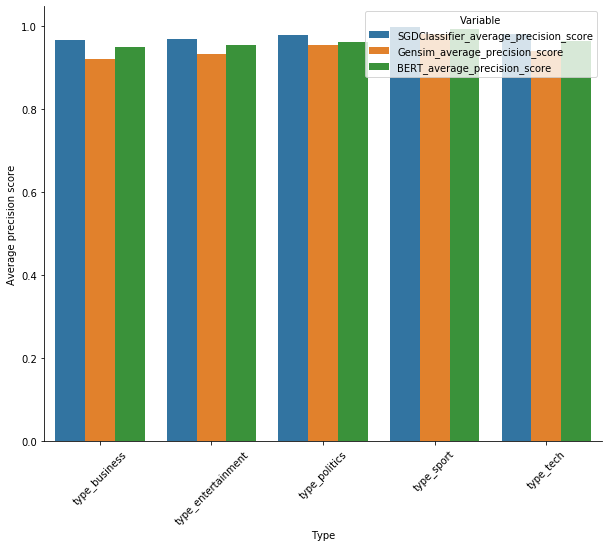

In [44]:
accuracy_classifier_melt.dropna(inplace=True)
fig, ax1 = plt.subplots(figsize=(10, 8))
type=sns.barplot(x='Type', y='Value', hue='Variable', data=accuracy_classifier_melt[-20:])
for item in type.get_xticklabels():
    item.set_rotation(45)
ax1.set(xlabel='Type', ylabel='Average precision score')
sns.despine(fig)

### Ratio of classification accuracy after summarization by Gensim vs original news 

In [45]:
accuracy_classifier.Gensim_average_precision_score.mean()/accuracy_classifier.SGDClassifier_average_precision_score.mean()

0.966597746908765

### Ratio of classification accuracy after BERT summarization vs original news 

In [46]:
accuracy_classifier.BERT_average_precision_score.mean()/accuracy_classifier.SGDClassifier_average_precision_score.mean()

0.9857600842511685

In [47]:
accuracy_classifier.to_csv('NewsPerformMetrics.csv')

### Conclusion: BERT Summarization performs better than Gensim Summarization 

In [48]:
news['BERT'][2]

"Yukos unit buyer faces loan claim\n \n The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (Ã\x82Â£479m) loan. Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks."

In [49]:
news['news'][2]

'Yukos unit buyer faces loan claim\n \n The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (Ã\x82Â£479m) loan. \n \n State-owned Rosneft bought the Yugansk unit for $9 bn in a sale forced by Russia to part settle a $27 bn tax claim against Yukos.  Yukos\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets.  Rosneft already faces a similar $540m repayment demand from foreign banks.  Legal experts said Rosneft\'s purchase of Yugansk would include such obligations.  "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case.  Menatep Group\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit. "\n \n 

In [50]:
# from gensim
news['newsSum'][2]

"State-owned Rosneft bought the Yugansk unit for $9 bn in a sale forced by Russia to part settle a $27 bn tax claim against Yukos.\nYukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets."